## Homework I ML in finance


authors: Summer Negahdar, Luna Jian, Jae Jung


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pyarrow.parquet as pq
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import mean_squared_error, r2_score

warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [3]:
gw_df= pd.read_csv("gw.csv")
lsret_df= pd.read_csv("lsret.csv", index_col=0)
FRED_df= pd.read_csv("FREDMD.csv")
largeml_df= pd.read_parquet("largeml.pq")
smallml_df= pd.read_parquet("smallml.pq")




In [4]:
#inspecting a few things:\
largeml_df.head(10)
smallml_df.head(10)

## I will be changing the yyyymm to datetime
largeml_df['date'] = pd.to_datetime(largeml_df['yyyymm'], format='%Y%m')
largeml_df = largeml_df.drop(columns='yyyymm')
largeml_df=largeml_df.set_index('date')

smallml_df['date'] = pd.to_datetime(smallml_df['yyyymm'], format='%Y%m')
smallml_df = smallml_df.drop(columns='yyyymm')
smallml_df=smallml_df.set_index('date')



In [5]:
## I will be dropping column with more than 30% missing value, and for those below the threshhold, I will impute with their mean
# for largeml
threshold = 0.3
missing_fractionL = largeml_df.isnull().mean()
largeml_df = largeml_df.loc[:, missing_fractionL <= threshold]
# Convert all columns to numeric, coercing errors to NaN
largeml_df = largeml_df.apply(pd.to_numeric, errors='coerce')
largeml_df=largeml_df.fillna(largeml_df.mean())

#for smallml
missing_fractionS = smallml_df.isnull().mean()
smallml_df = smallml_df.loc[:, missing_fractionS <= threshold]
# Convert all columns to numeric, coercing errors to NaN
smallml_df = smallml_df.apply(pd.to_numeric, errors='coerce')
smallml_df=smallml_df.fillna(smallml_df.mean())

#for lsret
missing_fractionLS= lsret_df.isnull().mean()
lsret_df=lsret_df.loc[:, missing_fractionLS <= threshold]

# Convert all columns to numeric, coercing errors to NaN (just in case)
lsret_df = lsret_df.apply(pd.to_numeric, errors='coerce')
lsret_df=lsret_df.fillna(lsret_df.mean())


### Question one

### Question Two

### Question Three


a. 

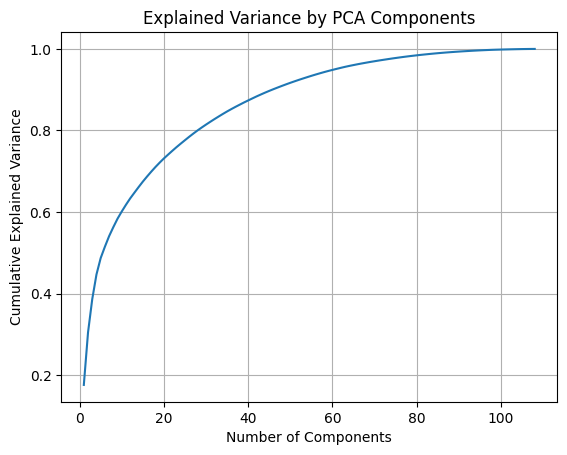

In [6]:
# I will scale first before doing PCA
scaler= StandardScaler()
lsret_df=lsret_df.apply(pd.to_numeric, errors='coerce')
lsret_df_scd= scaler.fit_transform(lsret_df)
# Run PCA
pca = PCA()
pca.fit(lsret_df_scd)

# Explained variance ratio
explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot how much variance is explained by # of components
plt.plot(range(1, len(explained_variance) + 1), explained_variance)
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance by PCA Components")
plt.grid(True)
plt.show()

### interpretation:
first of all, we have around 100 features (X-axis) which is smaller than original lsret after cleaning. it also shows that we can explain 100% of variation with all 100 portfolios. this means that we have done this correctly. 

we see a large jump in the first 20 PCs, increasing the interpretability to around 78%

In [7]:
# Finding the number of components needed to explain 90% of the variance
n_components_90 = np.argmax(explained_variance >= 0.9) + 1  # +1 because argmax returns 0-based index
print(f"Number of components needed to explain 90% of the variance is {n_components_90}")


Number of components needed to explain 90% of the variance is 46


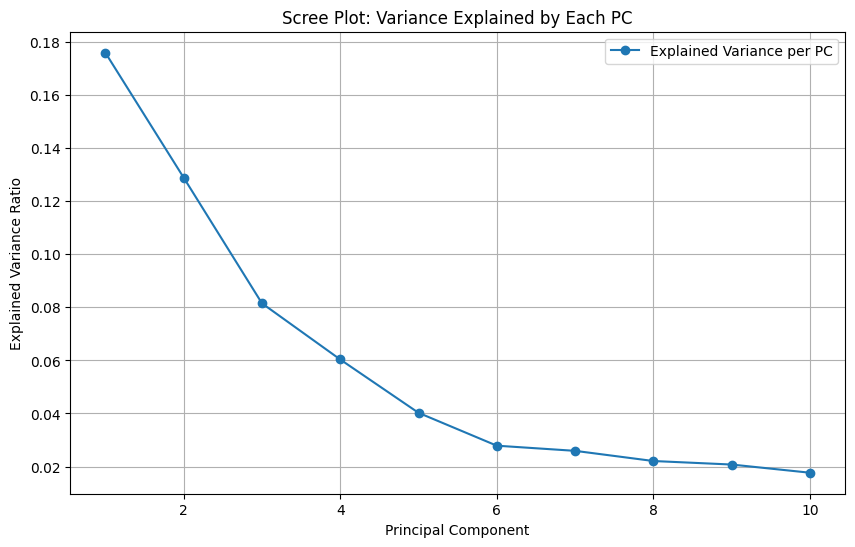

In [8]:
## I also want to draw a scree plot

n_pcs_to_show = min(10, len(pca.explained_variance_ratio_))
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_pcs_to_show + 1), pca.explained_variance_ratio_[:n_pcs_to_show], marker='o', linestyle='-', label='Explained Variance per PC')
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.title("Scree Plot: Variance Explained by Each PC")
plt.grid(True)
plt.legend()
plt.show()

b. 

In [9]:
print(lsret_df.columns)  # This will show you all column names
print(lsret_df.index)

Index(['AM', 'Accruals', 'AssetGrowth', 'BM', 'BMdec', 'Beta', 'BetaFP',
       'BetaTailRisk', 'BidAskSpread', 'BookLeverage',
       ...
       'VolSD', 'VolumeTrend', 'grcapx', 'grcapx3y', 'sinAlgo', 'std_turn',
       'tang', 'zerotrade12M', 'zerotrade1M', 'zerotrade6M'],
      dtype='object', length=108)
Index(['1926-01-30', '1926-02-27', '1926-03-31', '1926-04-30', '1926-05-28',
       '1926-06-30', '1926-07-31', '1926-08-31', '1926-09-30', '1926-10-30',
       ...
       '2023-03-31', '2023-04-28', '2023-05-31', '2023-06-30', '2023-07-31',
       '2023-08-31', '2023-09-29', '2023-10-31', '2023-11-30', '2023-12-29'],
      dtype='object', name='date', length=1176)


In [10]:
##introducing indicator column for all rows
lsret_df['indicator']= 1 

# Ensure index is datetime
# Separate the data into features and target
X = lsret_df.drop(columns=['indicator']) 
y = lsret_df['indicator']  # Indicator as the target

# Split the data into training/validation set (data prior to 2004) and test set (data after 2004)
train_data = lsret_df[lsret_df.index < '2004-01-01']  
test_data = lsret_df[lsret_df.index >= '2004-01-01']

# Prepare the features (X) and target (y) for training and testing
X_train = train_data.drop(columns=['indicator']) 
y_train = train_data['indicator']

X_test = test_data.drop(columns=['indicator'])
y_test = test_data['indicator']



In [11]:


# scaling features for LASSO and RR
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [12]:
y_train.value_counts(), y_test.value_counts()

(indicator
 1    936
 Name: count, dtype: int64,
 indicator
 1    240
 Name: count, dtype: int64)

In [13]:
# Step 5: Train LassoCV and Ridge models
# LassoCV will automatically perform cross-validation to select the best alpha
lasso_cv = LassoCV(cv=5, random_state=42, alphas=np.logspace(-6, 6, 13))  # 5-fold cross-validation for Lasso
lasso_cv.fit(X_train_scaled, y_train)  # Train the Lasso model

# Ridge model (with alpha parameter chosen)
alphas = np.logspace(-6, 6, 13)  # List of alphas to test for RidgeCV
ridge_cv = RidgeCV(alphas=alphas, store_cv_results=True)  # Initialize RidgeCV with alpha candidates
ridge_cv.fit(X_train_scaled, y_train)  # Train the Ridge model

# Step 6: Make predictions using the trained models
y_pred_lasso = lasso_cv.predict(X_test_scaled)  # LassoCV predictions
y_pred_ridge = ridge_cv.predict(X_test_scaled)  # Ridge predictions

# Step 7: Compute portfolio returns for both LassoCV and Ridge models
portfolio_lasso = y_pred_lasso
portfolio_ridge = y_pred_ridge


In [14]:
# Normalize weights
def normalize_weights(coef, model_name):
    total = np.sum(np.abs(coef))
    if total < 1e-10:
        print(f"Warning: {model_name} coefficients sum to near zero; using equal weights")
        return np.ones(len(coef)) / len(coef)
    return coef / total

    
w_lasso = normalize_weights(lasso_cv.coef_, "Lasso")
w_ridge = normalize_weights(ridge_cv.coef_, "Ridge")


# Form portfolio out-of-sample using the coefficients
# For Lasso model
portfolio_lasso = X_test_scaled @ w_lasso ## I had to use matrix complexity something!
portfolio_ridge = X_test_scaled @ w_ridge



the formula for sharpe ratio will be

$
\text{Sharpe Ratio} = \frac{\mathbb{E}[R_p] \times 12}{\sigma(R_p) \times \sqrt{12}}
$

In [16]:
# Step 8: Compute Sharpe ratios for the portfolios
def compute_sharpe(returns, model_name):
    mean = returns.mean() * 12  # Annualize mean return (12 months)
    std = returns.std() * np.sqrt(12)  # Annualize standard deviation (sqrt of 12 months)
    if std < 1e-10 or np.isnan(std):
        print(f"Warning: {model_name} portfolio has near-zero or NaN volatility")
        return np.nan
    return mean / std 

# Compute the Sharpe ratios for both Lasso and Ridge portfolios
sharpe_lasso = compute_sharpe(portfolio_lasso, "Lasso")
sharpe_ridge = compute_sharpe(portfolio_ridge, "Ridge")

# Print the results
print(f"Annualized Sharpe Ratio for Lasso Portfolio: {sharpe_lasso}")
print(f"Annualized Sharpe Ratio for Ridge Portfolio: {sharpe_ridge}")

Annualized Sharpe Ratio for Lasso Portfolio: -1.8932683764868345
Annualized Sharpe Ratio for Ridge Portfolio: -1.8932683764868345


#### interpretation

using pre-2004 data to predict post-2004 is not the smartest idea and that is why our sharpe ratio is negative. this could be interpreted that our portfolio is high risk and has excessive volatility!
all in all this is not a good model and does not have predictive power!


### c.

In [17]:
# Determine max factors (e.g., 95% variance or 10)
pca_temp = PCA().fit(X_train_scaled)
cum_variance = np.cumsum(pca_temp.explained_variance_ratio_)
max_factors = min(np.searchsorted(cum_variance, 0.95) + 1, X_train.shape[1], 10)
factor_counts = list(range(1, max_factors + 1))

# Initialize lists for Sharpe ratios
sharpe_lasso_list = []
sharpe_ridge_list = []

In [37]:
# PCA and lasso/ridge for each factor count
for n in factor_counts:
    try:
        # PCA
        pca = PCA(n_components=n)
        X_train_pca = pca.fit_transform(X_train_scaled)
        X_test_pca = pca.transform(X_test_scaled)
        
        # Scale PCA factors
        scaler_factors = StandardScaler()
        X_train_pca_scaled = scaler_factors.fit_transform(X_train_pca)
        X_test_pca_scaled = scaler_factors.transform(X_test_pca)
        
        # Lasso and ridge
        lasso = LassoCV(cv=5, random_state=42).fit(X_train_pca_scaled, y_train)
        ridge = RidgeCV(cv=5, alphas=[0.001, 0.01, 0.1, 1.0]).fit(X_train_pca_scaled, y_train)
        
        # Normalize weights
        def normalize_weights(coef, model_name, n_factors):
            total = np.sum(np.abs(coef))
            if total < 1e-10:
                print(f"Warning: {model_name} coefficients sum to near zero for {n_factors} factors; using equal weights")
                return np.ones(len(coef)) / len(coef)
            return coef / total
        
        w_lasso = normalize_weights(lasso.coef_, "Lasso", n)
        w_ridge = normalize_weights(ridge.coef_, "Ridge", n)
        
        # Portfolio returns
        port_lasso = pd.Series(X_test_pca_scaled @ w_lasso).rename(f'Lasso_{n}')
        port_ridge = pd.Series(X_test_pca_scaled @ w_ridge).rename(f'Ridge_{n}')
        
        # Sharpe ratios
        def compute_sharpe(returns, model_name, n_factors):
            mean = returns.mean() * 12
            std = returns.std() * np.sqrt(12)
            if std < 1e-10 or np.isnan(std):
                print(f"Warning: {model_name} portfolio has near-zero or NaN volatility for {n_factors} factors")
                return np.nan
            return mean / std
        
        sharpe_lasso = compute_sharpe(port_lasso, "Lasso", n)
        sharpe_ridge = compute_sharpe(port_ridge, "Ridge", n)
        
        sharpe_lasso_list.append(sharpe_lasso if not np.isnan(sharpe_lasso) else np.nan)
        sharpe_ridge_list.append(sharpe_ridge if not np.isnan(sharpe_ridge) else np.nan)
        
    except Exception as e:
        print(f"Error for {n} factors: {e}")
        sharpe_lasso_list.append(np.nan)
        sharpe_ridge_list.append(np.nan)

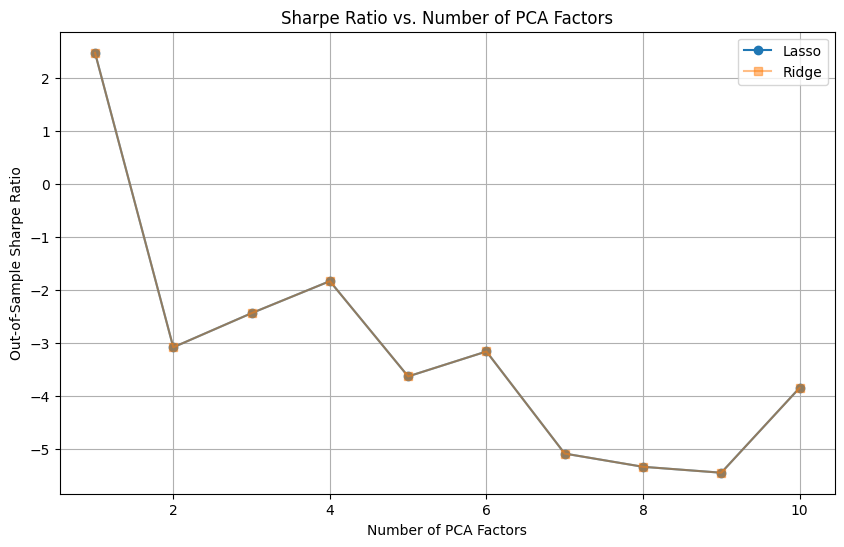

In [38]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(factor_counts, sharpe_lasso_list, marker='o', label='Lasso')
plt.plot(factor_counts, sharpe_ridge_list, marker='s',alpha= 0.5, label='Ridge')
plt.xlabel('Number of PCA Factors')
plt.ylabel('Out-of-Sample Sharpe Ratio')
plt.title('Sharpe Ratio vs. Number of PCA Factors')
plt.legend()
plt.grid(True)
plt.show()

they fall perfectly on each other, and also looking at thr R^2, we see that post 4th PC, we don't see much addition to the interpretation power. 
based on Fama-French factors, we want sharpe ratio to increase initially, showcasing the capturing of institutional differences in small numbers or PCA. 

R^2 (Proportion of Variance Explained) for Each PC:
PC1: R^2 = 0.3727, Cumulative R^2 = 0.3727
PC2: R^2 = 0.1377, Cumulative R^2 = 0.5104
PC3: R^2 = 0.0836, Cumulative R^2 = 0.5940
PC4: R^2 = 0.0696, Cumulative R^2 = 0.6635
PC5: R^2 = 0.0401, Cumulative R^2 = 0.7036
PC6: R^2 = 0.0331, Cumulative R^2 = 0.7367
PC7: R^2 = 0.0242, Cumulative R^2 = 0.7608
PC8: R^2 = 0.0219, Cumulative R^2 = 0.7828
PC9: R^2 = 0.0182, Cumulative R^2 = 0.8009
PC10: R^2 = 0.0165, Cumulative R^2 = 0.8174


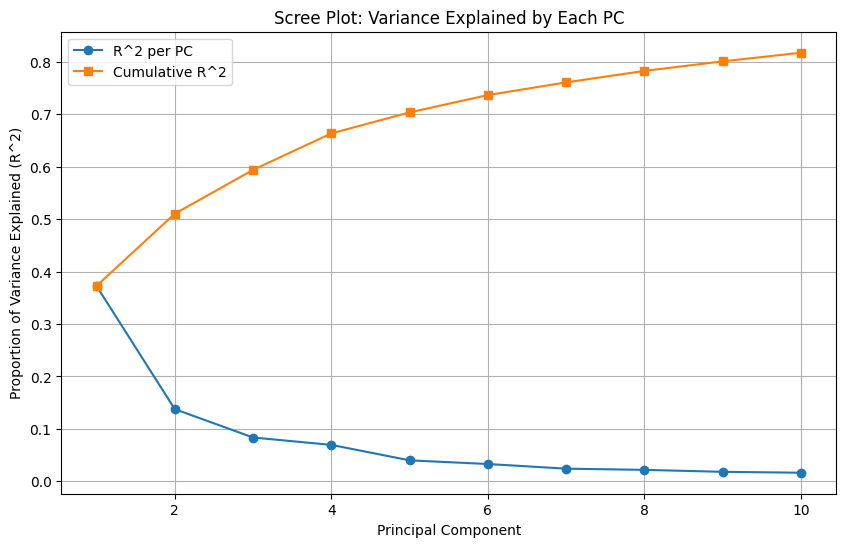

In [39]:
# Fit PCA to get R^2 for each PC
pca_full = PCA()
pca_full.fit(X_train_scaled)
r2_per_pc = pca_full.explained_variance_ratio_
cum_r2 = np.cumsum(r2_per_pc)
# Display R^2 for each PC (up to 10 or total PCs)
num_pcs_to_show = min(len(r2_per_pc), 10)
print("R^2 (Proportion of Variance Explained) for Each PC:")
for i in range(num_pcs_to_show):
    print(f"PC{i+1}: R^2 = {r2_per_pc[i]:.4f}, Cumulative R^2 = {cum_r2[i]:.4f}")

# Scree plot: I want to see how much R^2 each PC adds to the model
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_pcs_to_show + 1), r2_per_pc[:num_pcs_to_show], marker='o', label='R^2 per PC')
plt.plot(range(1, num_pcs_to_show + 1), cum_r2[:num_pcs_to_show], marker='s', label='Cumulative R^2')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained (R^2)')
plt.title('Scree Plot: Variance Explained by Each PC')
plt.legend()
plt.grid(True)
plt.show()


Loadings for the First 2 Principal Components:

PC1 (R^2 = 0.3727):
              Portfolio   Loading
16                 Beta  0.110805
21         BookLeverage  0.110092
171          ShareIss1Y -0.109998
128    NetEquityFinance -0.109952
195           fgr5yrLag -0.109237
129      NetPayoutYield -0.108836
149     PriceDelayTstat -0.108713
172          ShareIss5Y -0.108449
77   ForecastDispersion -0.108439
188                XFIN -0.108221


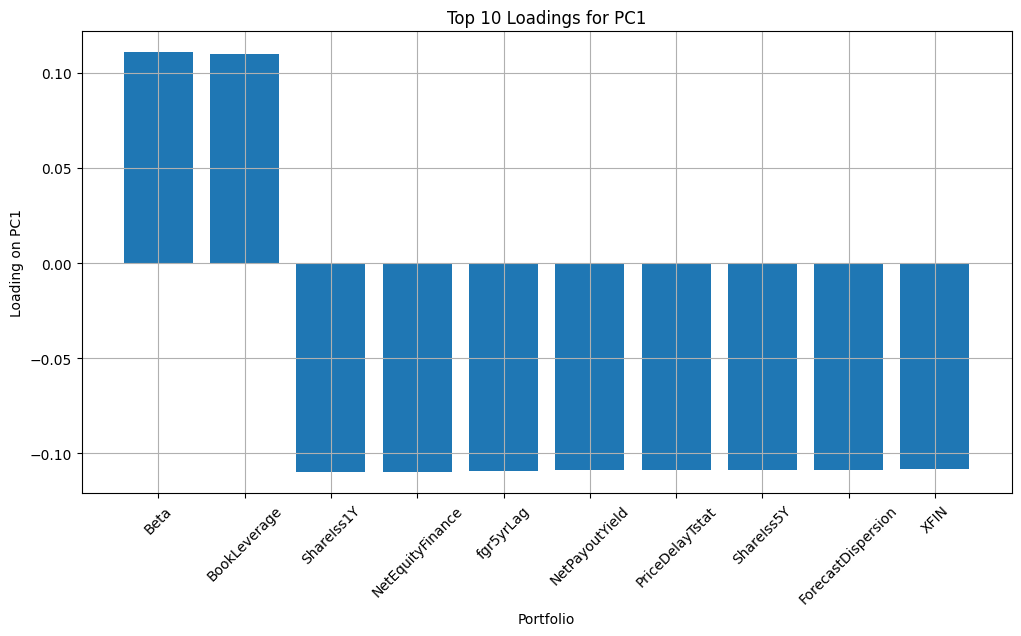


PC2 (R^2 = 0.1377):
        Portfolio   Loading
60         DolVol  0.161288
154           RDS  0.158813
52         DelEqu  0.155789
29           ChEQ  0.152027
176          Size  0.150263
114  MomOffSeason  0.148816
12    AssetGrowth  0.148349
100       IntanSP  0.148241
104    LRreversal  0.147161
198          hire  0.143192


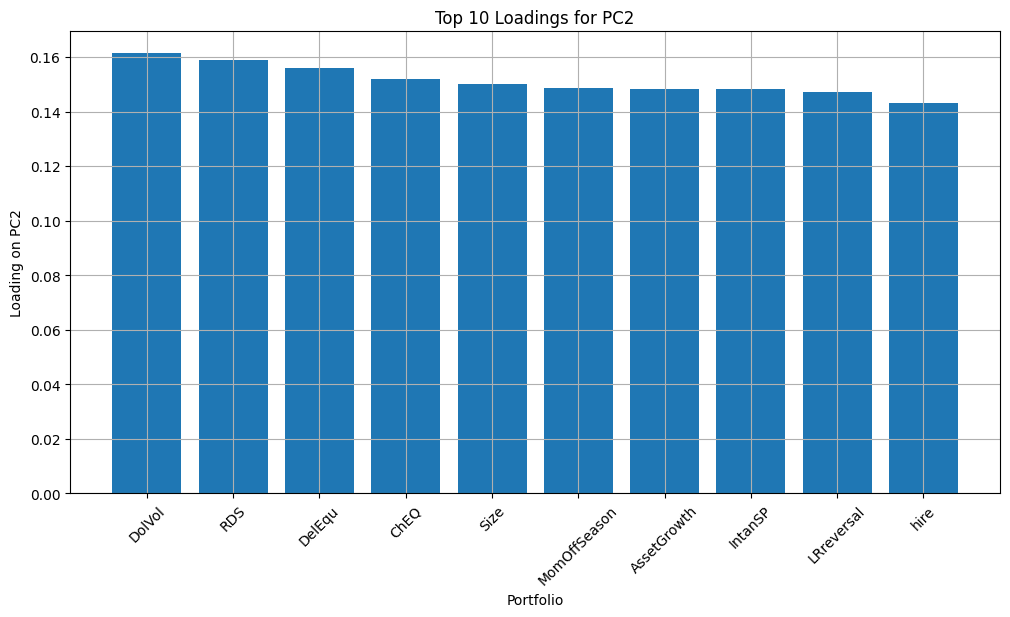

In [ ]:
##I want to see the details of the loadings. 
# Extract and interpret loadings for the first 3 PCs
num_pcs_to_interpret = min(2, pca_full.n_components_)
print("\nLoadings for the First 2 Principal Components:")
for i in range(num_pcs_to_interpret):
    loadings = pca_full.components_[i]
    # Map loadings to portfolio names
    loading_df = pd.DataFrame({
        'Portfolio': X_train.columns,
        'Loading': loadings
    })

# Sort by absolute loading for clarity
    loading_df = loading_df.reindex(loading_df['Loading'].abs().sort_values(ascending=False).index)
    print(f"\nPC{i+1} (R^2 = {r2_per_pc[i]:.4f}):")
    print(loading_df.head(10))  # Top 10 portfolios by absolute loading
    # Optional: Plot loadings
    plt.figure(figsize=(12, 6))
    plt.bar(loading_df['Portfolio'][:10], loading_df['Loading'][:10])
    plt.xlabel('Portfolio')
    plt.ylabel(f'Loading on PC{i+1}')
    plt.title(f'Top 10 Loadings for PC{i+1}')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

a few notes:
the negative Vs. postivie signs suggrsts that those certain portfolio loadings move in the opposite direction of each other.
but in terms of magnitude, most loadings in each pf these PCs have around the same size, suggesting that these effect that certain PC almost equally!
looking at all the charts we have, we want to keep only first PC because of the interpretability-complexity concerns. the sharpe ratio dropd drastically after PC1 and therefore there is not much incentive to use more than that!


d.

In [18]:
# Ensure datetime index
largeml_df.index = pd.to_datetime(largeml_df.index)

# Prepare data with constant indicator
largeml_df['indicator'] = 1


trainL = largeml_df[largeml_df.index < '2004-01-01']
testL = largeml_df[largeml_df.index >= '2004-01-01']
X_trainL = trainL.drop(columns='indicator')
y_trainL = trainL['indicator']
X_testL = testL.drop(columns='indicator')

# Scale features
scaler = StandardScaler()
X_train_scaledL = scaler.fit_transform(X_trainL)
X_test_scaledL = scaler.transform(X_testL)

# Lasso and ridge
lassoL = LassoCV(cv=5, random_state=42).fit(X_train_scaledL, y_trainL)
ridgeL = RidgeCV(cv=5, alphas=[0.001, 0.01, 0.1, 1.0]).fit(X_train_scaledL, y_trainL)

# Step 6: Make predictions using the trained models
y_pred_lassoL = lassoL.predict(X_test_scaledL)  # LassoCV predictions
y_pred_ridgeL = ridgeL.predict(X_test_scaledL)  # Ridge predictions

# Step 7: Compute portfolio returns for both LassoCV and Ridge models
portfolio_lassoL = y_pred_lassoL
portfolio_ridgeL = y_pred_ridgeL

# Normalize weights
def normalize_weights(coef, model_name):
    total = np.sum(np.abs(coef))
    if total < 1e-10:
        print(f"Warning: {model_name} coefficients sum to near zero; using equal weights")
        return np.ones(len(coef)) / len(coef)
    return coef / total

    
w_lassoL = normalize_weights(lassoL.coef_, "Lasso")
w_ridgeL = normalize_weights(ridgeL.coef_, "Ridge")


# Form portfolio out-of-sample using the coefficients
# For Lasso model
portfolio_lassoL = X_test_scaledL @ w_lassoL ## I had to use matrix complexity something!
portfolio_ridgeL = X_test_scaledL @ w_ridgeL

# Compute Sharpe ratios
def compute_sharpe(returns, model_name):
    mean = returns.mean() * 12  # Annualize mean return
    std = returns.std() * np.sqrt(12)  # Annualize standard deviation
    if std < 1e-10 or np.isnan(std):
        print(f"Warning: {model_name} portfolio has near-zero or NaN volatility")
        return np.nan
    return mean / std

# Calculate Sharpe ratios for both LassoCV and RidgeCV portfolios
sharpe_lassoL = compute_sharpe(portfolio_lassoL, "Lasso")
sharpe_ridgeL = compute_sharpe(portfolio_ridgeL, "Ridge")

# Output the Sharpe ratios
print(f"Annualized Sharpe Ratio for LassoCV Portfolio on largeml dataset: {sharpe_lassoL}")
print(f"Annualized Sharpe Ratio for RidgeCV Portfolio on largeml dataset: {sharpe_ridgeL}")


Annualized Sharpe Ratio for LassoCV Portfolio on largeml dataset: -0.04401206818308386
Annualized Sharpe Ratio for RidgeCV Portfolio on largeml dataset: -0.04401206818308386


In [19]:


# Ensure datetime index
smallml_df.index = pd.to_datetime(smallml_df.index)

# Prepare data with constant indicator
smallml_df['indicator'] = 1

trainS = smallml_df[smallml_df.index < '2004-01-01']
testS = smallml_df[smallml_df.index >= '2004-01-01']
X_trainS = trainS.drop(columns='indicator')
y_trainS = trainS['indicator']
X_testS = testS.drop(columns='indicator')

# Scale features
scaler = StandardScaler()
X_train_scaledS = scaler.fit_transform(X_trainS)
X_test_scaledS = scaler.transform(X_testS)

# Lasso and Ridge
lassoS = LassoCV(cv=5, random_state=42, max_iter=50000, tol=1e-3, alphas=np.logspace(-10, -4, 50)).fit(X_train_scaledS, y_trainS)
ridgeS = RidgeCV(cv=5, alphas=[0.001, 0.01, 0.1, 1.0]).fit(X_train_scaledS, y_trainS)

# Step 6: Make predictions using the trained models
y_pred_lassoS = lassoS.predict(X_test_scaledS)  # LassoCV predictions
y_pred_ridgeS = ridgeS.predict(X_test_scaledS)  # Ridge predictions

# Step 7: Compute portfolio returns for both LassoCV and Ridge models
portfolio_lassoS = y_pred_lassoS
portfolio_ridgeS = y_pred_ridgeS

# Normalize weights
def normalize_weights(coef, model_name):
    total = np.sum(np.abs(coef))
    if total < 1e-10:
        print(f"Warning: {model_name} coefficients sum to near zero; using equal weights")
        return np.ones(len(coef)) / len(coef)
    return coef / total

w_lassoS = normalize_weights(lassoS.coef_, "Lasso")
w_ridgeS = normalize_weights(ridgeS.coef_, "Ridge")

# Form portfolio out-of-sample using the coefficients
portfolio_lassoS = X_test_scaledS @ w_lassoS
portfolio_ridgeS = X_test_scaledS @ w_ridgeS

# Compute Sharpe ratios
def compute_sharpe(returns, model_name):
    mean = returns.mean() * 12  # Annualize mean return
    std = returns.std() * np.sqrt(12)  # Annualize standard deviation
    if std < 1e-10 or np.isnan(std):
        print(f"Warning: {model_name} portfolio has near-zero or NaN volatility")
        return np.nan
    return mean / std

# Calculate Sharpe ratios for both LassoCV and RidgeCV portfolios
sharpe_lassoS = compute_sharpe(portfolio_lassoS, "Lasso")
sharpe_ridgeS = compute_sharpe(portfolio_ridgeS, "Ridge")

# Output the Sharpe ratios
print(f"Annualized Sharpe Ratio for LassoCV Portfolio on smallml dataset: {sharpe_lassoS}")
print(f"Annualized Sharpe Ratio for RidgeCV Portfolio on smallml dataset: {sharpe_ridgeS}")

Annualized Sharpe Ratio for LassoCV Portfolio on smallml dataset: 0.5551267392627824
Annualized Sharpe Ratio for RidgeCV Portfolio on smallml dataset: 0.5551267392627824


the sharpe ratio for large cap data is still negative but much better than short-long return portfolio. it is even better on small cap portfolio (aorund 0.55)
it makes sense since it is less complicated and thus does not overfit. 

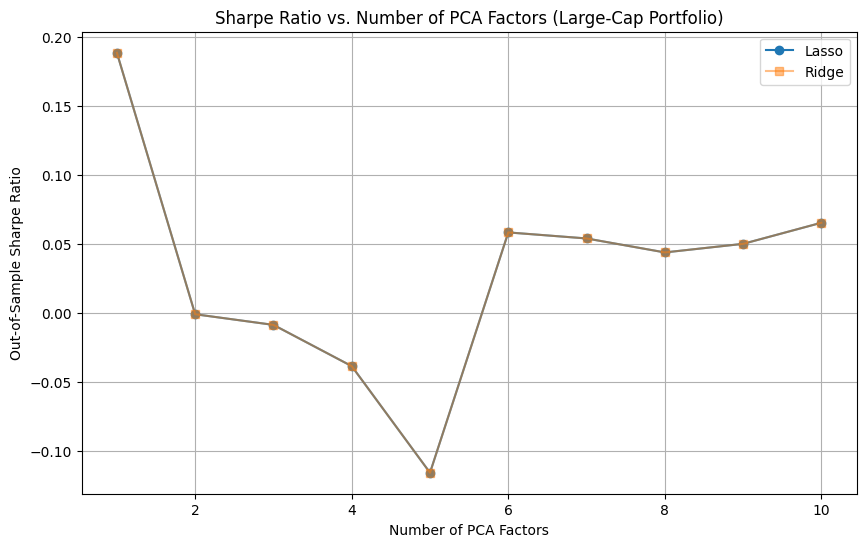

R^2 (Proportion of Variance Explained) for Each PC:
PC1: R^2 = 0.0787, Cumulative R^2 = 0.0787
PC2: R^2 = 0.0547, Cumulative R^2 = 0.1334
PC3: R^2 = 0.0482, Cumulative R^2 = 0.1816
PC4: R^2 = 0.0433, Cumulative R^2 = 0.2249
PC5: R^2 = 0.0328, Cumulative R^2 = 0.2577
PC6: R^2 = 0.0323, Cumulative R^2 = 0.2900
PC7: R^2 = 0.0307, Cumulative R^2 = 0.3207
PC8: R^2 = 0.0248, Cumulative R^2 = 0.3455
PC9: R^2 = 0.0239, Cumulative R^2 = 0.3694
PC10: R^2 = 0.0236, Cumulative R^2 = 0.3930


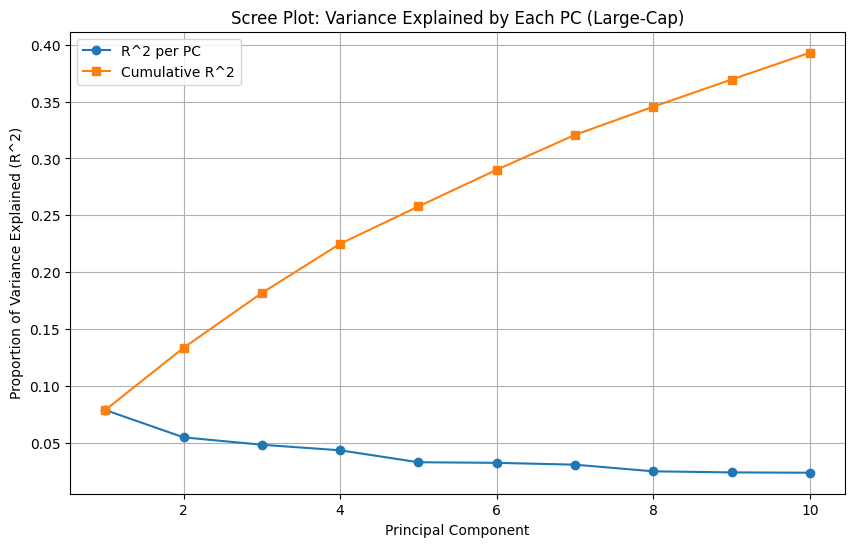

In [20]:
# Determine max factors (e.g., 95% variance or 10)
pca_tempL = PCA().fit(X_train_scaledL)
cum_varianceL = np.cumsum(pca_tempL.explained_variance_ratio_)
max_factorsL = min(np.searchsorted(cum_varianceL, 0.95) + 1, X_trainL.shape[1], 10)
factor_countsL = list(range(1, max_factorsL + 1))

# Initialize lists for Sharpe ratios
sharpe_lasso_listL = []
sharpe_ridge_listL = []

for n in factor_countsL:
    try:
        # PCA
        pcaL = PCA(n_components=n)
        X_train_pcaL = pcaL.fit_transform(X_train_scaledL)
        X_test_pcaL = pcaL.transform(X_test_scaledL)

        # Scale PCA factors
        scaler_factorsL = StandardScaler()
        X_train_pca_scaledL = scaler_factorsL.fit_transform(X_train_pcaL)
        X_test_pca_scaledL = scaler_factorsL.transform(X_test_pcaL)

        # Lasso and Ridge
        lassoL = LassoCV(cv=5, random_state=42).fit(X_train_pca_scaledL, y_trainL)
        ridgeL = RidgeCV(cv=5, alphas=[0.001, 0.01, 0.1, 1.0]).fit(X_train_pca_scaledL, y_trainL)

        def normalize_weightsL(coef, model_name, n_factors):
            total = np.sum(np.abs(coef))
            if total < 1e-10:
                print(f"Warning: {model_name} coefficients sum to near zero for {n_factors} factors; using equal weights")
                return np.ones(len(coef)) / len(coef)
            return coef / total

        w_lassoL = normalize_weightsL(lassoL.coef_, "Lasso", n)
        w_ridgeL = normalize_weightsL(ridgeL.coef_, "Ridge", n)

        port_lassoL = pd.Series(X_test_pca_scaledL @ w_lassoL).rename(f'Lasso_{n}')
        port_ridgeL = pd.Series(X_test_pca_scaledL @ w_ridgeL).rename(f'Ridge_{n}')

        def compute_sharpeL(returns, model_name, n_factors):
            mean = returns.mean() * 12
            std = returns.std() * np.sqrt(12)
            if std < 1e-10 or np.isnan(std):
                print(f"Warning: {model_name} portfolio has near-zero or NaN volatility for {n_factors} factors")
                return np.nan
            return mean / std

        sharpe_lassoL = compute_sharpeL(port_lassoL, "Lasso", n)
        sharpe_ridgeL = compute_sharpeL(port_ridgeL, "Ridge", n)

        sharpe_lasso_listL.append(sharpe_lassoL if not np.isnan(sharpe_lassoL) else np.nan)
        sharpe_ridge_listL.append(sharpe_ridgeL if not np.isnan(sharpe_ridgeL) else np.nan)

    except Exception as e:
        print(f"Error for {n} factors: {e}")
        sharpe_lasso_listL.append(np.nan)
        sharpe_ridge_listL.append(np.nan)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(factor_countsL, sharpe_lasso_listL, marker='o', label='Lasso')
plt.plot(factor_countsL, sharpe_ridge_listL, marker='s', alpha=0.5, label='Ridge')
plt.xlabel('Number of PCA Factors')
plt.ylabel('Out-of-Sample Sharpe Ratio')
plt.title('Sharpe Ratio vs. Number of PCA Factors (Large-Cap Portfolio)')
plt.legend()
plt.grid(True)
plt.show()

# Fit PCA to get R^2 for each PC
pca_fullL = PCA()
pca_fullL.fit(X_train_scaledL)
r2_per_pcL = pca_fullL.explained_variance_ratio_
cum_r2L = np.cumsum(r2_per_pcL)

num_pcs_to_showL = min(len(r2_per_pcL), 10)
print("R^2 (Proportion of Variance Explained) for Each PC:")
for i in range(num_pcs_to_showL):
    print(f"PC{i+1}: R^2 = {r2_per_pcL[i]:.4f}, Cumulative R^2 = {cum_r2L[i]:.4f}")

# Scree plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_pcs_to_showL + 1), r2_per_pcL[:num_pcs_to_showL], marker='o', label='R^2 per PC')
plt.plot(range(1, num_pcs_to_showL + 1), cum_r2L[:num_pcs_to_showL], marker='s', label='Cumulative R^2')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained (R^2)')
plt.title('Scree Plot: Variance Explained by Each PC (Large-Cap)')
plt.legend()
plt.grid(True)
plt.show()

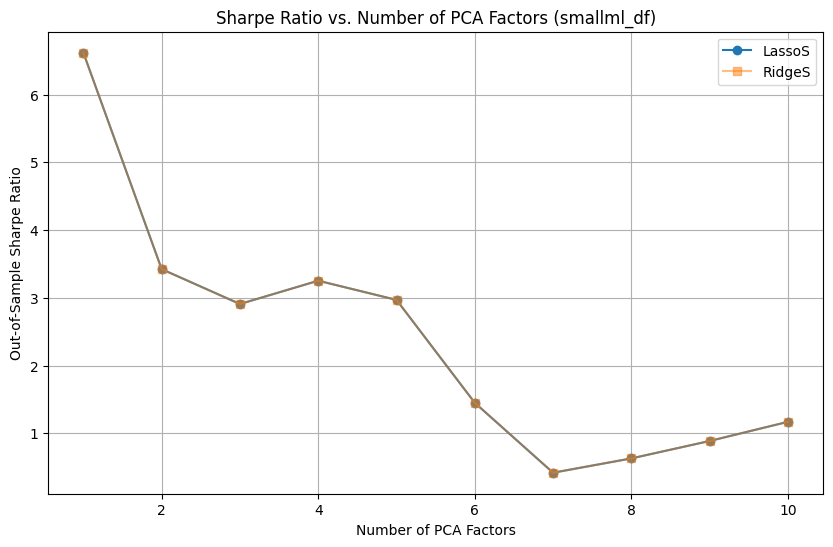

R^2 (Proportion of Variance Explained) for Each PC:
PC1: R^2 = 0.2440, Cumulative R^2 = 0.2440
PC2: R^2 = 0.1468, Cumulative R^2 = 0.3908
PC3: R^2 = 0.1073, Cumulative R^2 = 0.4982
PC4: R^2 = 0.0738, Cumulative R^2 = 0.5719
PC5: R^2 = 0.0597, Cumulative R^2 = 0.6316
PC6: R^2 = 0.0499, Cumulative R^2 = 0.6814
PC7: R^2 = 0.0490, Cumulative R^2 = 0.7305
PC8: R^2 = 0.0462, Cumulative R^2 = 0.7766
PC9: R^2 = 0.0430, Cumulative R^2 = 0.8196
PC10: R^2 = 0.0396, Cumulative R^2 = 0.8593


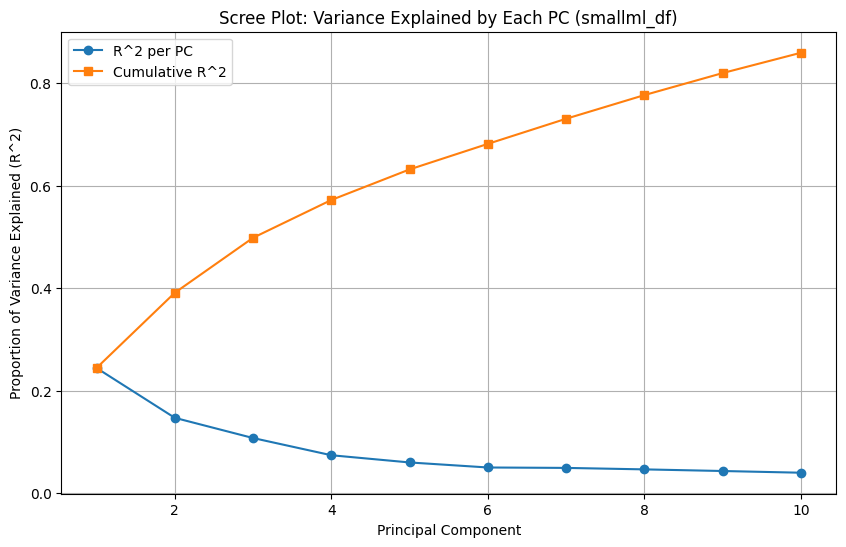

In [23]:
# === PCA, Lasso, Ridge for smallml_df ===

# Determine max factors (e.g., 95% variance or 10)
pca_tempS = PCA().fit(X_train_scaledS)
cum_varianceS = np.cumsum(pca_tempS.explained_variance_ratio_)
max_factorsS = min(np.searchsorted(cum_varianceS, 0.95) + 1, X_trainS.shape[1], 10)
factor_countsS = list(range(1, max_factorsS + 1))

# Initialize lists for Sharpe ratios
sharpe_lasso_listS = []
sharpe_ridge_listS = []

for n in factor_countsS:
    try:
        # PCA
        pcaS = PCA(n_components=n)
        X_train_pcaS = pcaS.fit_transform(X_train_scaledS)
        X_test_pcaS = pcaS.transform(X_test_scaledS)

        # Scale PCA factors
        scaler_factorsS = StandardScaler()
        X_train_pca_scaledS = scaler_factorsS.fit_transform(X_train_pcaS)
        X_test_pca_scaledS = scaler_factorsS.transform(X_test_pcaS)

        # Lasso and Ridge
        lassoS = LassoCV(cv=5, random_state=42).fit(X_train_pca_scaledS, y_trainS)
        ridgeS = RidgeCV(cv=5, alphas=[0.001, 0.01, 0.1, 1.0]).fit(X_train_pca_scaledS, y_trainS)

        # Normalize weights
        def normalize_weightsS(coef, model_name, n_factors):
            total = np.sum(np.abs(coef))
            if total < 1e-10:
                print(f"Warning: {model_name} coefficients sum to near zero for {n_factors} factors; using equal weights")
                return np.ones(len(coef)) / len(coef)
            return coef / total

        w_lassoS = normalize_weightsS(lassoS.coef_, "Lasso", n)
        w_ridgeS = normalize_weightsS(ridgeS.coef_, "Ridge", n)

        # Portfolio returns
        port_lassoS = pd.Series(X_test_pca_scaledS @ w_lassoS).rename(f'Lasso_{n}')
        port_ridgeS = pd.Series(X_test_pca_scaledS @ w_ridgeS).rename(f'Ridge_{n}')

        # Sharpe ratios
        def compute_sharpeS(returns, model_name, n_factors):
            mean = returns.mean() * 12
            std = returns.std() * np.sqrt(12)
            if std < 1e-10 or np.isnan(std):
                print(f"Warning: {model_name} portfolio has near-zero or NaN volatility for {n_factors} factors")
                return np.nan
            return mean / std

        sharpe_lasso = compute_sharpeS(port_lassoS, "Lasso", n)
        sharpe_ridge = compute_sharpeS(port_ridgeS, "Ridge", n)

        sharpe_lasso_listS.append(sharpe_lasso if not np.isnan(sharpe_lasso) else np.nan)
        sharpe_ridge_listS.append(sharpe_ridge if not np.isnan(sharpe_ridge) else np.nan)

    except Exception as e:
        print(f"Error for {n} factors: {e}")
        sharpe_lasso_listS.append(np.nan)
        sharpe_ridge_listS.append(np.nan)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(factor_countsS, sharpe_lasso_listS, marker='o', label='LassoS')
plt.plot(factor_countsS, sharpe_ridge_listS, marker='s', alpha=0.5, label='RidgeS')
plt.xlabel('Number of PCA Factors')
plt.ylabel('Out-of-Sample Sharpe Ratio')
plt.title('Sharpe Ratio vs. Number of PCA Factors (smallml_df)')
plt.legend()
plt.grid(True)
plt.show()

# Scree plot
pca_fullS = PCA()
pca_fullS.fit(X_train_scaledS)
r2_per_pcS = pca_fullS.explained_variance_ratio_
cum_r2S = np.cumsum(r2_per_pcS)

num_pcs_to_showS = min(len(r2_per_pcS), 10)
print("R^2 (Proportion of Variance Explained) for Each PC:")
for i in range(num_pcs_to_showS):
    print(f"PC{i+1}: R^2 = {r2_per_pcS[i]:.4f}, Cumulative R^2 = {cum_r2S[i]:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_pcs_to_showS + 1), r2_per_pcS[:num_pcs_to_showS], marker='o', label='R^2 per PC')
plt.plot(range(1, num_pcs_to_showS + 1), cum_r2S[:num_pcs_to_showS], marker='s', label='Cumulative R^2')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained (R^2)')
plt.title('Scree Plot: Variance Explained by Each PC (smallml_df)')
plt.legend()
plt.grid(True)
plt.show()

### Interpretation

it got super interesting. for large cap dataset we get a small variation even with 10 PCs (aorund 39%) while with 10 PC we can explain 85% of the variance. however for all the datasets our sharpe ratio gets worse as we increase the number of PCs!


#### e.


ok so 1 PC is giving us the best Sharpe ratio and thus I will just apply that!
therefore I will just use PC1 in my ideal portfolio. there is also no difference between lasso and RR. so I just choose Lasso!
